In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from models.losses import *
from pathlib import Path
from utils.plot import *
from utils.forward import *
from tqdm import tqdm
from skimage import metrics
from skimage.util.shape import view_as_windows
from sklearn.utils import shuffle
from utils.preprocessing import *

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
np.random.seed(0)

In [4]:
n_layers = 35
kernel_size = 3
PATCH_SIZE = (32, 32, 1)
to_interp = True
lr_axis = None
k = None
ACQ_DIM = 2
N_CORES = 6

In [6]:
ROOT_DIR = Path("/iacl/pg20/sam/data/ADNI_phantom/")
IN_FNAME = ROOT_DIR / "SUPERRES-ADNIPHANTOM_20200711_PHANTOM-T2-TSE-2D-CORONAL-PRE-ACQ1-05mm.nii"
nii_obj = nib.load(IN_FNAME)
*_, imgs_aliased = process_nii_obj(
        nii_obj,
        n_layers=n_layers,
        patch_size=PATCH_SIZE,
        kernel_size=kernel_size,
        to_interp=to_interp,
        lr_axis=lr_axis,
        k=k,
        n_rots=0,
        n_cores=N_CORES,
        acq_dim=ACQ_DIM,
        train=True,
        window_option=None,
        verbose=True,
    )
img_aliased = imgs_aliased[0].copy()
imgs_aliased = None
del imgs_aliased

========== PREPROCESSING IMAGE ==========
Digitally upsampling...
	Elapsed time to digitally upsample: 32.1075s
Applying blur to rotated images...
	Elapsed time to apply blur: 0.4096s
Applying aliasing to blurred images...
	Elapsed time to apply aliasing: 2.4078s
========== PREPROCESSING FINISHED ==========
	Elapsed time to preprocess: 34.9318s


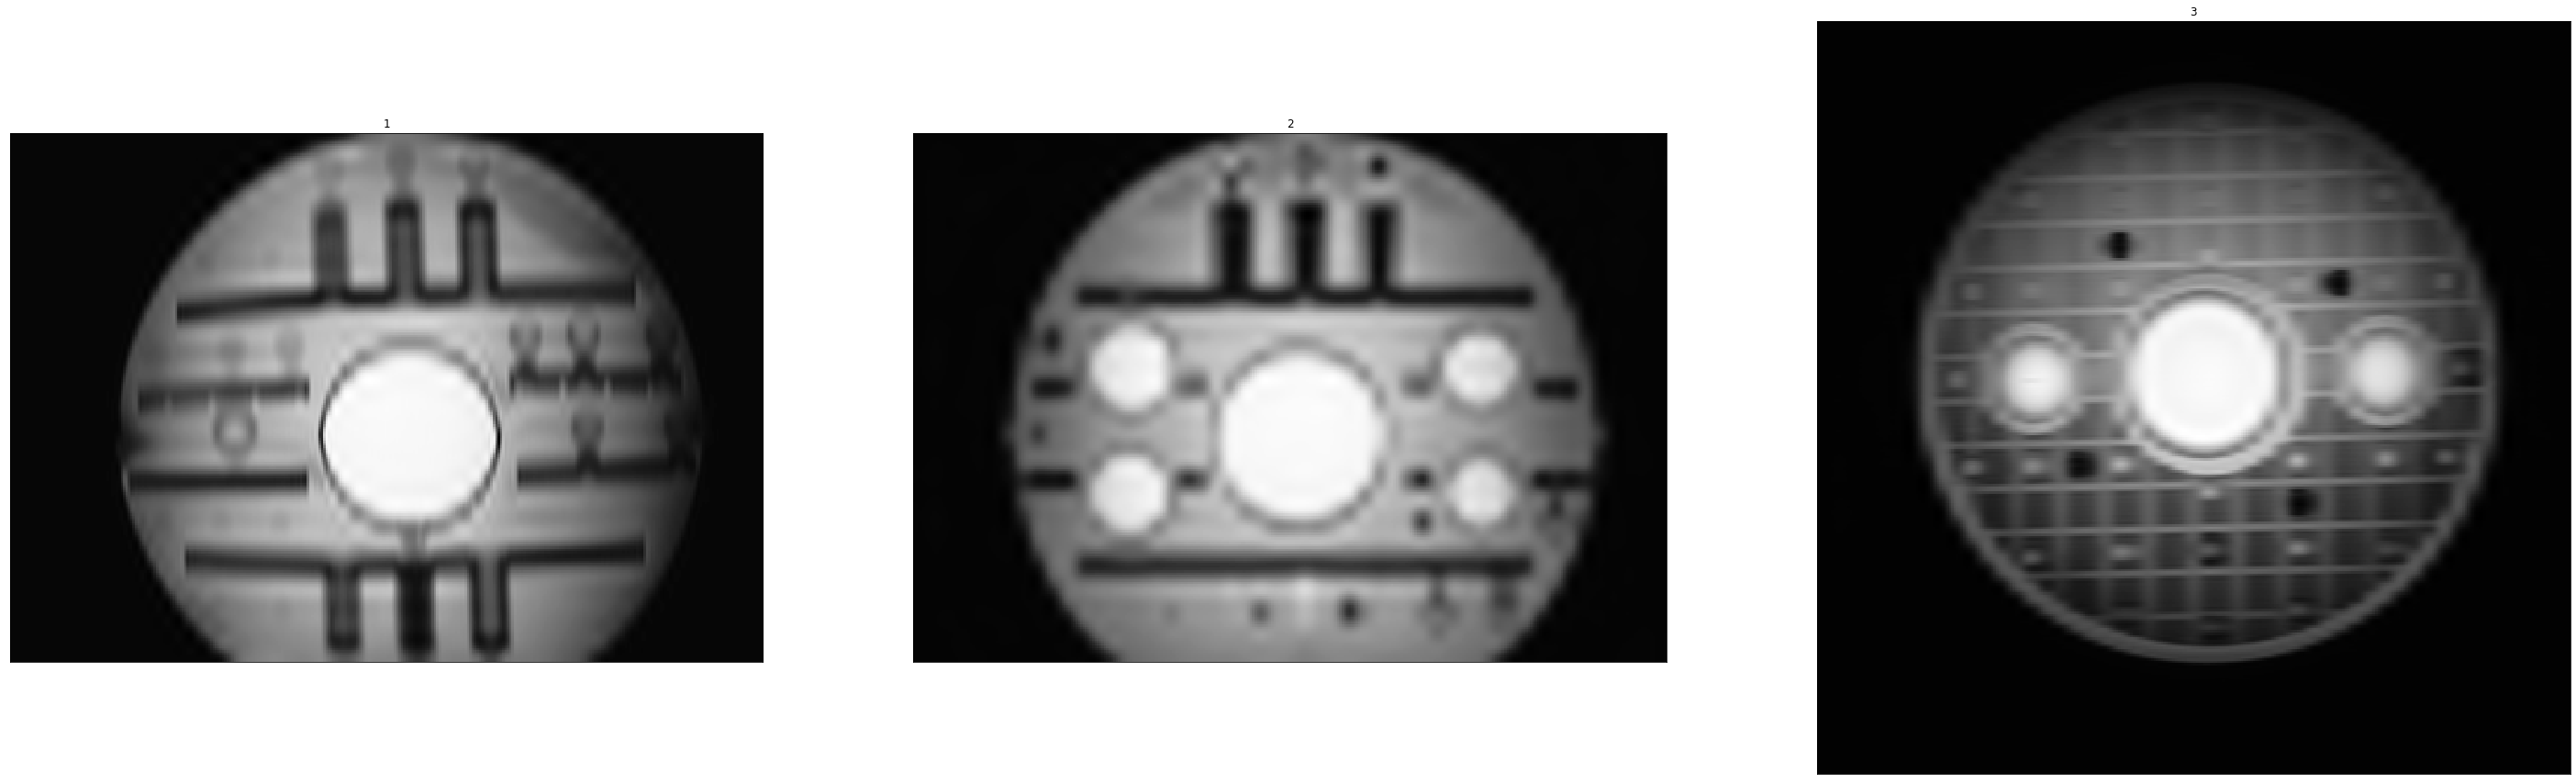

In [7]:
center_vol_plot(img_aliased)

# Fit AE

In [8]:
def running_average(old_average, cur_val, n):
    return old_average * (n-1)/n + cur_val/n

In [9]:
def get_training_pair(
        views_list_x,
        indices,
        patch_size,
        batch_size,
        seed,
):

    index = iter(indices)
    xs = np.zeros((batch_size, *patch_size), dtype=np.float32)

    idx_order = list(range(batch_size))
    idx_order = shuffle(idx_order, random_state=seed)

    for insertion_idx in range(batch_size):
        i = next(index)

        # Take copies for the batch to allow augmentation
        x = views_list_x[i].copy()

        xs[idx_order[insertion_idx]] = x

    xs = tf.convert_to_tensor(xs)

    return xs, xs

In [10]:
train_setup = {
    'xy': img_aliased,
    'yz': img_aliased.transpose(1,2,0),
    'xz': img_aliased.transpose(0,2,1),
}

models = {}

for mode, img in train_setup.items():
    
    print("Indexing and shuffling patches...")
    st = time.time()
    views_list_x = view_as_windows(img, PATCH_SIZE)
    indices = list(np.ndindex(views_list_x.shape[:len(PATCH_SIZE)]))

    indices = shuffle(indices, random_state=0)
    en = time.time()
    print(
        "\tElapsed time to index and shuffle patches: {:.4f}s".format(en-st))
    

    # model
    inputs = tf.keras.layers.Input(shape=PATCH_SIZE)

    a = tf.keras.layers.Conv2D(
        filters=8,
        kernel_size=3,
        strides=1,
        padding='same',
        activation='linear',
    )(inputs)

    # Final convolution
    outputs = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=3,
        strides=1,
        padding='same',
        activation='linear',
    )(a)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    models[mode] = model

    opt = tf.optimizers.Adam(learning_rate=1e-2)
    train_loss = tf.keras.metrics.Mean(name="train_loss")
    BATCH_SIZE = 2**12
    loss_fn = l2_loss
    N_STEPS = 2000000 // BATCH_SIZE
    TEMPLATE = "\rStep {: <4d}/{: <4d} | Loss: {:.4f} | {: <10.2f}s/step  |  ETA: {: 10.2f}s"
    elapsed = 0.0
    seed = 0

    for cur_step in range(N_STEPS):
        st = time.time()
        seed += 1

        train_batch = get_training_pair(
            views_list_x,
            indices,
            patch_size=PATCH_SIZE,
            batch_size=BATCH_SIZE,
            seed=seed,
        )

        # Logits are the predictions here
        grads, loss, preds = forward(
            inputs=train_batch,
            model=model,
            loss_fn=loss_fn,
            training=True,
        )

        train_loss.update_state(loss)

        opt.apply_gradients(zip(grads, model.trainable_variables))
        en = time.time()
        elapsed = running_average(elapsed, en-st, cur_step+1)
        eta = (N_STEPS - cur_step) * elapsed
        print(
            TEMPLATE.format(
                cur_step+1,
                N_STEPS,
                train_loss.result(),
                elapsed,
                eta,
            ),
            end="",
        )
    print()

Indexing and shuffling patches...
	Elapsed time to index and shuffle patches: 16.1905s
Step 488 /488  | Loss: 14324.5674 | 0.11      s/step  |  ETA:       0.11sIndexing and shuffling patches...
	Elapsed time to index and shuffle patches: 21.2921s
Step 488 /488  | Loss: 11692.1338 | 0.08      s/step  |  ETA:       0.08sIndexing and shuffling patches...
	Elapsed time to index and shuffle patches: 20.6637s
Step 488 /488  | Loss: 39327.9414 | 0.08      s/step  |  ETA:       0.08sss

In [11]:
models

{'xy': <tensorflow.python.keras.engine.training.Model at 0x7f9e137f1ed0>,
 'yz': <tensorflow.python.keras.engine.training.Model at 0x7f9eb5c84350>,
 'xz': <tensorflow.python.keras.engine.training.Model at 0x7f9eb5a1a250>}

In [28]:
models['xy'].layers[2].get_weights()[0].mean()

-0.012530167

In [29]:
models['yz'].layers[2].get_weights()[0].mean()

-0.0029681448

In [30]:
models['xz'].layers[2].get_weights()[0].mean()

0.017296435

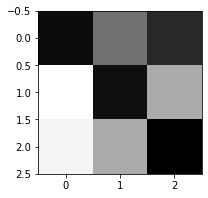

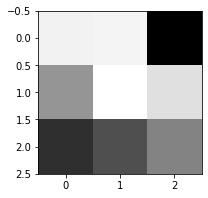

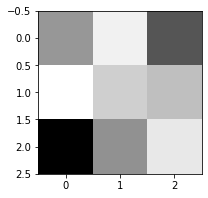

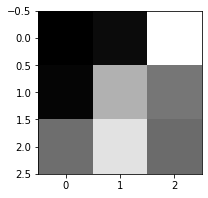

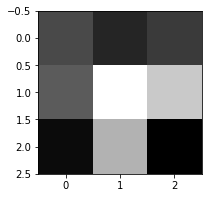

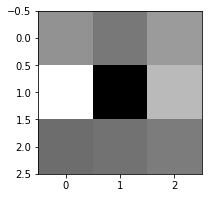

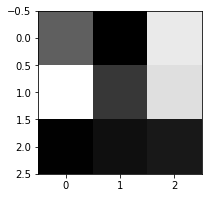

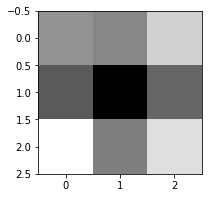

In [22]:
for i in range(8):
    kernel = models['xy'].layers[1].get_weights()[0]
    plt.figure(figsize=(3,3))
    plt.imshow(kernel[...,0,i])
    plt.show()

In [36]:
def yield_prediction_batch(
    views_list,
    indices,
    batch_size,
    patch_size,
):

    index = iter(indices)
    xs = np.zeros((batch_size, *patch_size), dtype=np.float32)

    while True:
        # fill the batch
        try:
            for b in range(batch_size):
                i = next(index)
                x = views_list[i].copy()
                xs[b] = x
        except StopIteration:
            b -= 1
            break
        finally:
            yield xs[:b+1]

## In-plane x-y results

In [46]:
# predict
views = view_as_windows(imgs_aliased[0], PATCH_SIZE)
pred_indices = np.ndindex(views.shape[:len(PATCH_SIZE)])
pred_iter = yield_prediction_batch(views, pred_indices, BATCH_SIZE, PATCH_SIZE)

In [56]:
test_loss_xy = tf.keras.metrics.Mean(name="test_loss_xy")

TEMPLATE = "\rStep {: <4d}/{: <4d} | Loss: {:.4f} | {: <10.2f}s/step  |  ETA: {: 10.2f}s"
cur_step = 0
N_STEPS = len(indices)//BATCH_SIZE+1

for i, xs in enumerate(pred_iter):
    st = time.time()
    ys_hat = model(xs, training=False)
    loss = l2_loss(xs, ys_hat)
    
    test_loss_xy.update_state(loss)
    
    en = time.time()
    elapsed = running_average(elapsed, en-st, cur_step+1)
    eta = (N_STEPS - cur_step) * elapsed
    
    print(
        TEMPLATE.format(
            cur_step+1,
            N_STEPS,
            test_loss_xy.result(),
            elapsed,
            eta,
        ),
        end="",
    )
    cur_step += 1

Step 4298/4588 | Loss: 13604.8877 | 0.11      s/step  |  ETA:      33.29s

## Through-plane x-z results

In [57]:
# predict
views = view_as_windows(imgs_aliased[0].transpose(0,2,1), PATCH_SIZE)
pred_indices = np.ndindex(views.shape[:len(PATCH_SIZE)])
pred_iter = yield_prediction_batch(views, pred_indices, BATCH_SIZE, PATCH_SIZE)

In [58]:
test_loss_xz = tf.keras.metrics.Mean(name="test_loss_xz")

TEMPLATE = "\rStep {: <4d}/{: <4d} | Loss: {:.4f} | {: <10.2f}s/step  |  ETA: {: 10.2f}s"
cur_step = 0
N_STEPS = len(indices)//BATCH_SIZE+1

for i, xs in enumerate(pred_iter):
    st = time.time()
    ys_hat = model(xs, training=False)
    loss = l2_loss(xs, ys_hat)
    
    test_loss_xz.update_state(loss)
    
    en = time.time()
    elapsed = running_average(elapsed, en-st, cur_step+1)
    eta = (N_STEPS - cur_step) * elapsed
    
    print(
        TEMPLATE.format(
            cur_step+1,
            N_STEPS,
            test_loss_xz.result(),
            elapsed,
            eta,
        ),
        end="",
    )
    cur_step += 1

Step 4381/4588 | Loss: 6281.8438 | 0.11      s/step  |  ETA:      23.78s

## Through-plane y-z results

In [59]:
# predict
views = view_as_windows(imgs_aliased[0].transpose(1,2,0), PATCH_SIZE)
pred_indices = np.ndindex(views.shape[:len(PATCH_SIZE)])
pred_iter = yield_prediction_batch(views, pred_indices, BATCH_SIZE, PATCH_SIZE)

In [60]:
test_loss_yz = tf.keras.metrics.Mean(name="test_loss_xz")

TEMPLATE = "\rStep {: <4d}/{: <4d} | Loss: {:.4f} | {: <10.2f}s/step  |  ETA: {: 10.2f}s"
cur_step = 0
N_STEPS = len(indices)//BATCH_SIZE+1

for i, xs in enumerate(pred_iter):
    st = time.time()
    ys_hat = model(xs, training=False)
    loss = l2_loss(xs, ys_hat)
    
    test_loss_yz.update_state(loss)
    
    en = time.time()
    elapsed = running_average(elapsed, en-st, cur_step+1)
    eta = (N_STEPS - cur_step) * elapsed
    
    print(
        TEMPLATE.format(
            cur_step+1,
            N_STEPS,
            test_loss_yz.result(),
            elapsed,
            eta,
        ),
        end="",
    )
    cur_step += 1

Step 4381/4588 | Loss: 13347.1396 | 0.11      s/step  |  ETA:      23.80s